<a href="https://colab.research.google.com/github/P4P3RCL1P/HopLogData/blob/main/Log_file_root_cause_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Persistent connection to github repository through deployment key

#XGBoost classification

**What is XGBoost?**

XGBoost (Semi-Supervised Gradient Boosting)

* Many weak learners (shallow trees) can together make a more accurate predictor





Gradient Boosting
* Idea: Can a weak learner be modified to become better?
  * Can we transform a series of weak/poor hypotheses into one very good hypothesis?
* First main boosting algorithm: AdaBoost (Adaptive Boosting)
  * Weak learners are decision trees with a single split called decision stumps
  * Observations are weighted based on their difficulty in being classified (observations that are harder to classify are assigned a higher weight)
  * To make predictions majority voting is used based on the ensemble of weak learners and a weight assigned based on their individual accuracy score
* What is gradient boosting?
  * Acts as a statistical framework where the goal is to minimize the loss of the model by adding weak learners using a gradient descent like procedure.
* Components of gradient boosting
  * Loss function (to be optimized)
    * In our case, we use logarithmic loss
    * Gradient boosting is generic enough where different loss functions can be used
  * Weak learner (to make predictions)
    * Uses regression trees to output values for splits which is then added together for subsequent trees to take the output and improve/correct upon it.
  * An additive model (to add learners to minimize the loss function)
    * Since gradient boosting uses a tree structure, weak learners are added to previous parents to enhance/minimize the loss function
    * A fixed number of trees are added or training stops once loss reaches an acceptable level or no longer improves the validation dataset

**Regularization**
* Idea: Reduce the prediction’s sensitivity to individual observations
* Regression that prohibits a more complex/flexible model, avoiding the model becoming greedy in capturing noise found in your dataset. (Helps with overfitting)
**A Unique Regression Tree**
* Before constructing the regression trees we have to create an initial prediction score which will help with the classification/regression task (ex: if we want to classify whether a drug is effective or not we can create a prediction that 0.5 effectiveness is our initial boundary)
* XGBoost Tree
  * For Regression
    * A tree starts as a root node, which maps all the residual data points to it
    * The quality/similarity score is calculated for these data points. 
    * Similarity Score = Similarity Score =Sum of Residuals(data points), SquaredNumber / Number of Residuals + Lambda
      * When the residuals in a node are very different, they cancel each other out and the Similarity Score is relatively small.
      * When the residuals are similar, or there is just one residual, they do not cancel out and the Similarity Score is relatively large.
    * Lambda is a Regularization parameter, used for filtering out noise in the data.
      * When lambda is greater than 0, the similarity scores are smaller
      * The amount of decrease is inversely proportional to the number of residuals in the node
      * When lambda is greater than 0, it is easier to prune leaves because the gain values are smaller.
    * After calculating the similarity for the root first leaf we ask whether or not the similarity could improve if we split the residuals into two different groups. (For our drug effectiveness example, if we split the drugs based on whether their dosage is less than 15mg, will that have an effect on the similarity score?)
    * Residuals are sorted into their new groups based on the condition set
    * To see how much better the leaf branches similarity scores do from the original node’s similarity score we calculate the gain of splitting the residuals into n groups
    * Gain =LeftSimilarity + RightSimilarity-RootSimilarity
    * After the gain for a specific threshold has been calculated we move to a new threshold and perform a similar methodology of calculating the similarity scores and then the gain. We compare the gain scores and choose the best splitting value based on the total gain scores
    * The split with the highest gain score is set as the branch for that tree.
    * Continue splitting while the node contains more than one value
    * Try all the available thresholds for this new split and compute the best split again by comparing all the computed gain scores.
    * If a tree isn’t at the default XGBoost tree level of 6 we prune the tree
      * We prune the tree based on its gain values which we attribute to the parameter  (gamma)
      * Starting with the lowest branch, we subtract the branches gain score from gamma, and if the difference between the gain and gamma is negative, we remove the branch.
    * How are predictions calculated?
      * XGBoost makes new predictions by starting with the initial prediction
      * New prediction  = Original prediction +( The output of the tree (Sum of Residuals / Number of Residuals + Lambda ) + Learning Rate X)
        * (eta) is the learning rate. The default value is 0.3 

In [2]:
import numpy as np 
import pandas as pd 

#tokenization
from textblob import TextBlob

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# sklearn 
from sklearn import model_selection
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics.pairwise import cosine_similarity


# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [3]:
RAW_LOG_DATA_WITH_ERRORS = 'https://raw.githubusercontent.com/P4P3RCL1P/HopLogData/main/3-27-22.txt'

RAW_LOG_DATA_WITHOUT_ERRORS = 'https://github.com/P4P3RCL1P/HopLogData/blob/main/3-28-22.txt#L29'

train = pd.read_csv(RAW_LOG_DATA_WITH_ERRORS, sep=' - ', header=None, names =["Time", "Action", "LoggingText", "isError"])
train.head(60)

,Time,Action,LoggingText,isError
0,2022/03/27 11:46:49,Hop,Projects enabled,0
1,2022/03/27 11:46:49,Hop,Enabling project : 'default',0
2,2022/03/27 11:47:45,Hop,Starting workflow,0
3,2022/03/27 11:47:45,demoLineage,Start of workflow execution,0
4,2022/03/27 11:47:45,demoLineage,Logging workflow information to Neo4j connecti...,0
5,2022/03/27 11:47:48,demoLineage,ERROR: Error logging to Neo4j:,1
6,2022/03/27 11:47:48,demoLineage,ERROR: org.neo4j.driver.exceptions.ServiceUnav...,1
7,2022/03/27 11:47:48,demoLineage,\tat org.neo4j.driver.GraphDatabase.routingDri...,1
8,2022/03/27 11:47:48,demoLineage,\tat org.apache.hop.neo4j.shared.NeoConnection...,1
9,2022/03/27 11:47:48,demoLineage,\tat org.apache.hop.neo4j.shared.NeoConnection...,1


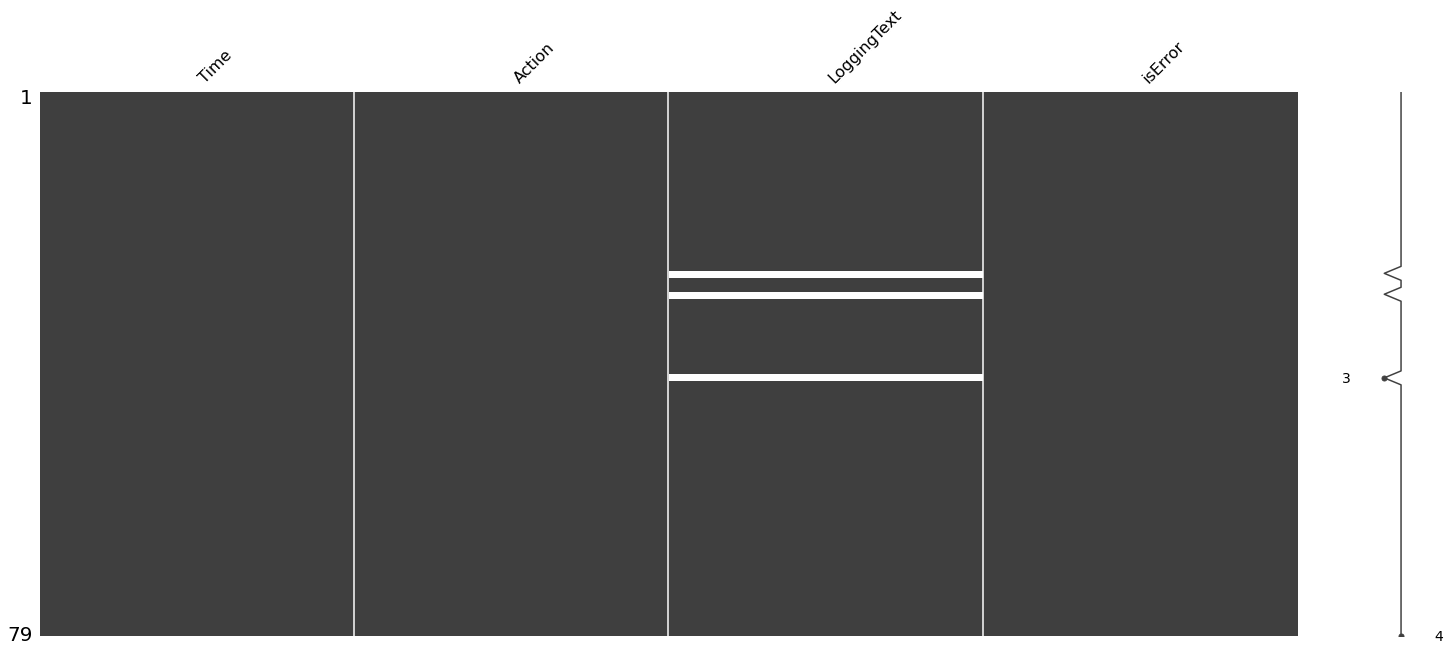

In [4]:
import missingno as msno
msno.matrix(df=train)

In [5]:
train.fillna("", inplace = True)
train.head(60)

,Time,Action,LoggingText,isError
0,2022/03/27 11:46:49,Hop,Projects enabled,0
1,2022/03/27 11:46:49,Hop,Enabling project : 'default',0
2,2022/03/27 11:47:45,Hop,Starting workflow,0
3,2022/03/27 11:47:45,demoLineage,Start of workflow execution,0
4,2022/03/27 11:47:45,demoLineage,Logging workflow information to Neo4j connecti...,0
5,2022/03/27 11:47:48,demoLineage,ERROR: Error logging to Neo4j:,1
6,2022/03/27 11:47:48,demoLineage,ERROR: org.neo4j.driver.exceptions.ServiceUnav...,1
7,2022/03/27 11:47:48,demoLineage,\tat org.neo4j.driver.GraphDatabase.routingDri...,1
8,2022/03/27 11:47:48,demoLineage,\tat org.apache.hop.neo4j.shared.NeoConnection...,1
9,2022/03/27 11:47:48,demoLineage,\tat org.apache.hop.neo4j.shared.NeoConnection...,1


In [6]:
#preprocess for filler data or null values
train["LoggingText"].replace('', np.nan, inplace=True)
train.dropna(subset=['LoggingText'], inplace = True)
train.head(60)

,Time,Action,LoggingText,isError
0,2022/03/27 11:46:49,Hop,Projects enabled,0
1,2022/03/27 11:46:49,Hop,Enabling project : 'default',0
2,2022/03/27 11:47:45,Hop,Starting workflow,0
3,2022/03/27 11:47:45,demoLineage,Start of workflow execution,0
4,2022/03/27 11:47:45,demoLineage,Logging workflow information to Neo4j connecti...,0
5,2022/03/27 11:47:48,demoLineage,ERROR: Error logging to Neo4j:,1
6,2022/03/27 11:47:48,demoLineage,ERROR: org.neo4j.driver.exceptions.ServiceUnav...,1
7,2022/03/27 11:47:48,demoLineage,\tat org.neo4j.driver.GraphDatabase.routingDri...,1
8,2022/03/27 11:47:48,demoLineage,\tat org.apache.hop.neo4j.shared.NeoConnection...,1
9,2022/03/27 11:47:48,demoLineage,\tat org.apache.hop.neo4j.shared.NeoConnection...,1


In [7]:
train = train[train["LoggingText"].str.contains(r'^(?=.*=======================================)')==False]
train = train[train["LoggingText"].str.contains(r'^]')==False]


In [8]:
train.shape

(73, 4)

In [9]:
train.head(60)

,Time,Action,LoggingText,isError
0,2022/03/27 11:46:49,Hop,Projects enabled,0
1,2022/03/27 11:46:49,Hop,Enabling project : 'default',0
2,2022/03/27 11:47:45,Hop,Starting workflow,0
3,2022/03/27 11:47:45,demoLineage,Start of workflow execution,0
4,2022/03/27 11:47:45,demoLineage,Logging workflow information to Neo4j connecti...,0
5,2022/03/27 11:47:48,demoLineage,ERROR: Error logging to Neo4j:,1
6,2022/03/27 11:47:48,demoLineage,ERROR: org.neo4j.driver.exceptions.ServiceUnav...,1
7,2022/03/27 11:47:48,demoLineage,\tat org.neo4j.driver.GraphDatabase.routingDri...,1
8,2022/03/27 11:47:48,demoLineage,\tat org.apache.hop.neo4j.shared.NeoConnection...,1
9,2022/03/27 11:47:48,demoLineage,\tat org.apache.hop.neo4j.shared.NeoConnection...,1


In [10]:
#row number was not sequential after regex so reset indices
train.reset_index()

,index,Time,Action,LoggingText,isError
0,0,2022/03/27 11:46:49,Hop,Projects enabled,0
1,1,2022/03/27 11:46:49,Hop,Enabling project : 'default',0
2,2,2022/03/27 11:47:45,Hop,Starting workflow,0
3,3,2022/03/27 11:47:45,demoLineage,Start of workflow execution,0
4,4,2022/03/27 11:47:45,demoLineage,Logging workflow information to Neo4j connecti...,0
...,...,...,...,...,...
68,74,2022/03/27 11:47:54,demoLineage,Finished action [DB CONNECTION ERRORS] (result...,0
69,75,2022/03/27 11:47:54,demoLineage,Finished action [Check DB connections] (result...,0
70,76,2022/03/27 11:47:54,demoLineage,Workflow execution finished,0
71,77,2022/03/27 11:47:54,Hop,Workflow execution has ended,0


In [11]:
test = train.iloc[:, 0:3]

In [12]:
train['Action'].describe()

count              73
unique              9
top       demoLineage
freq               33
Name: Action, dtype: object

In [13]:
print(train.dtypes)

Time           object
Action         object
LoggingText    object
isError         int64
dtype: object


# Classification using RegEx

Using RegEx assumes knowledge of the system environment and of areas where issues can occur. Our question is whether we can perform classification of whether a line in our log file is an error with minimal knowledge of the system domain. This acts as an introduction for how we can classify whether something is an error or not, but our implemented machine learning models will show a greater accuracy even after passing over the log data once.


In [41]:
regExErrorClass = test 


#classify text as containing errors if the following keywords are present
regList = [('Error'), ('ERROR:'), ('\tat ')]
for r in regList:
  #if any string in the Logging Text column contains or matches any of the regular expressions classify it as 1 for True
  regExErrorClass.loc[regExErrorClass['LoggingText'].str.contains(r[0], regex = False) == True, 'isError'] = 1

#fill in all other values as false (they didn't meet the regex criteria)
regExErrorClass['isError'] = regExErrorClass['isError'].replace("", 0)
regExErrorClass['isError'].fillna(0, inplace = True)


In [42]:
regExErrorClass

,Time,Action,LoggingText,isError
0,2022/03/27 11:46:49,Hop,Projects enabled,0.0
1,2022/03/27 11:46:49,Hop,Enabling project : 'default',1.0
2,2022/03/27 11:47:45,Hop,Starting workflow,0.0
3,2022/03/27 11:47:45,demoLineage,Start of workflow execution,0.0
4,2022/03/27 11:47:45,demoLineage,Logging workflow information to Neo4j connecti...,1.0
...,...,...,...,...
74,2022/03/27 11:47:54,demoLineage,Finished action [DB CONNECTION ERRORS] (result...,1.0
75,2022/03/27 11:47:54,demoLineage,Finished action [Check DB connections] (result...,0.0
76,2022/03/27 11:47:54,demoLineage,Workflow execution finished,0.0
77,2022/03/27 11:47:54,Hop,Workflow execution has ended,0.0


In [43]:
#compare the predicted labels against the training dataset labels to determine the model accuracy/f1/recall/precision
print("Classification metrics:")
y_pred = regExErrorClass['isError']
y_pred = y_pred.astype(np.int64)
y_true = train['isError']
y_true = y_true.astype(np.int64)

print(f"Accuracy score: {accuracy_score(y_true, y_pred)}")
print(f"F1 score: {f1_score(y_true, y_pred)}")
print(f"Recall: {recall_score(y_true, y_pred)} ")
print(f"Precision: {precision_score(y_true, y_pred)} ")


Classification metrics:
Accuracy score: 0.821917808219178
F1 score: 0.8433734939759037
Recall: 0.8974358974358975 
Precision: 0.7954545454545454 


A better classification model using regular expressions requires a more in-depth understanding of the structure behind the log file which can become cumbersome and time consuming. Instead, can we automate a classification model without any knowledge about the inherit structure of the logs?

# NLP (Natural language processing) preprocessing strategy

In order to build our classification model, we need data to feed it. Log data presents an interesting problem since most of the data is presented in a string format. To combat this issue we introduce natural language processing which helps detect patterns in our logging text, and which can then be used in classification of where errors are present.

In [50]:
train['LoggingText'] = train['LoggingText'].replace([None], [""], regex=True)
test['LoggingText'] = test['LoggingText'].replace([None], [""], regex=True)

In [51]:
train.head(40)

,Time,Action,LoggingText,isError
0,2022/03/27 11:46:49,Hop,Projects enabled,0
1,2022/03/27 11:46:49,Hop,Enabling project : 'default',0
2,2022/03/27 11:47:45,Hop,Starting workflow,0
3,2022/03/27 11:47:45,demoLineage,Start of workflow execution,0
4,2022/03/27 11:47:45,demoLineage,Logging workflow information to Neo4j connecti...,0
5,2022/03/27 11:47:48,demoLineage,ERROR: Error logging to Neo4j:,1
6,2022/03/27 11:47:48,demoLineage,ERROR: org.neo4j.driver.exceptions.ServiceUnav...,1
7,2022/03/27 11:47:48,demoLineage,\tat org.neo4j.driver.GraphDatabase.routingDri...,1
8,2022/03/27 11:47:48,demoLineage,\tat org.apache.hop.neo4j.shared.NeoConnection...,1
9,2022/03/27 11:47:48,demoLineage,\tat org.apache.hop.neo4j.shared.NeoConnection...,1


In [52]:
print(train['isError'].value_counts())

1    39
0    34
Name: isError, dtype: int64


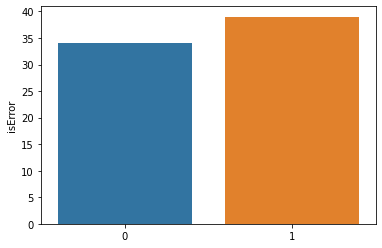

In [53]:
#distribution among errors and non-errors is roughly equal
sns.barplot(train['isError'].value_counts().index, train['isError'].value_counts())

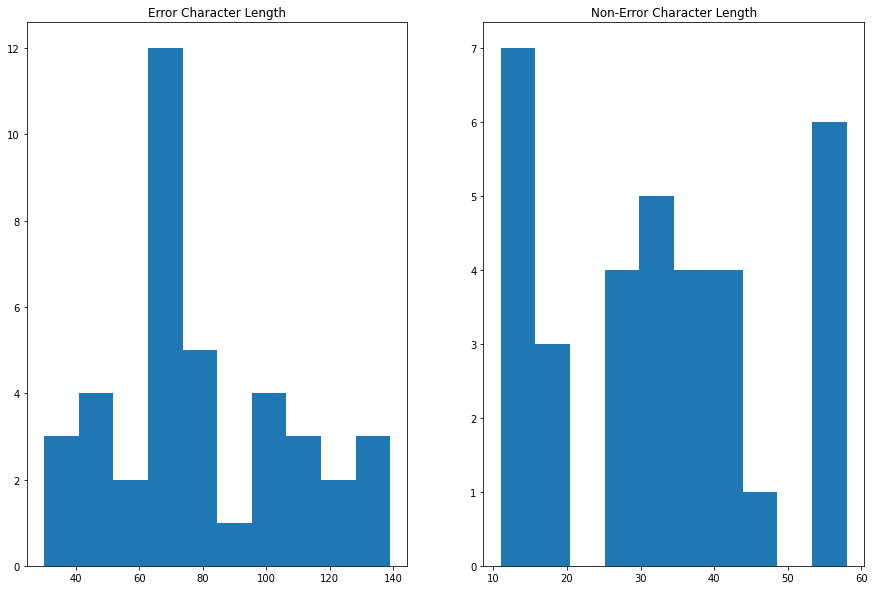

In [55]:
#how do the character lengths for logs w/ errors compare to non-error log messages
errorCharLen = train[train['isError']==1]['LoggingText'].str.len()
nonErrorCharLen = train[train['isError']==0]['LoggingText'].str.len()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 10))

ax1.hist(errorCharLen)
ax1.set_title("Error Character Length")

ax2.hist(nonErrorCharLen)
ax2.set_title("Non-Error Character Length")

plt.show()

The non-error character length histogram is being overwhelmed by values which don't contain text. Future preprocessing should remove these lines from the dataset since they don't add to the classification model

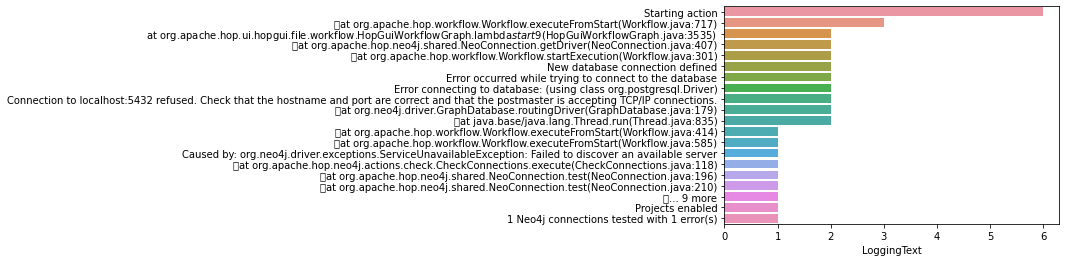

In [57]:
#Top 20 words based on prevalence in the log file
sns.barplot(y = train['LoggingText'].value_counts()[:20].index, x=train['LoggingText'].value_counts()[:20])



**What is count vectorization?**

Count all the occurences in a document or paragraph and keep track of the count of these words in a 'bag-of-words' to be used for future analysis

In the below example we perform count vectorization without tokenization. Tokenization is used to break larger text into words or sentences, while additionaly normalizing the data to remove punctuation and filler words. Tokenization allows the model to better understand the sequence of words for a given line in our log file.



In [58]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
loggingTextList = []
#test = ['Projects enabled' "Enabling project : 'default'" 'Starting workflow' 'Start of workflow execution' 'Logging workflow information to Neo4j connection : Example' 'ERROR: Error logging to Neo4j:' 'ERROR: org.neo4j.driver.exceptions.ServiceUnavailableException: Failed to discover an available server', '\tat org.neo4j.driver.GraphDatabase.routingDriver(GraphDatabase.java:179)', '\tat org.apache.hop.neo4j.shared.NeoConnection.getDriver(NeoConnection.java:407)', '\tat org.apache.hop.neo4j.shared.NeoConnection.getSession(NeoConnection.java:175)', '\tat org.apache.hop.neo4j.logging.xp.WorkflowLoggingExtensionPoint.callExtensionPoint(WorkflowLoggingExtensionPoint.java:87)', '\tat org.apache.hop.neo4j.logging.xp.WorkflowLoggingExtensionPoint.callExtensionPoint(WorkflowLoggingExtensionPoint.java:49)', '\tat org.apache.hop.core.extension.ExtensionPointMap.callExtensionPoint(ExtensionPointMap.java:147)', '\tat org.apache.hop.core.extension.ExtensionPointHandler.callExtensionPoint(ExtensionPointHandler.java:38)', '\tat org.apache.hop.workflow.Workflow.executeFromStart(Workflow.java:368)', '\tat org.apache.hop.workflow.Workflow.startExecution(Workflow.java:301)', '\tat org.apache.hop.ui.hopgui.file.workflow.HopGuiWorkflowGraph.lambda$start$9(HopGuiWorkflowGraph.java:3535)', '\tat java.base/java.lang.Thread.run(Thread.java:835)', 'exec(0, 0, Start)', 'Starting action', 'Starting action [Check DB connections]', 'exec(1, 0, Check DB connections)', 'Starting action', 'New database connection defined', 'ERROR: Cannot connect to database [dvdrental] (connection [dvdrental]). Exception : [org.apache.hop.core.exception.HopDatabaseException:', 'Error occurred while trying to connect to the database', '', 'Error connecting to database: (using class org.postgresql.Driver)' 'Connection to localhost:5432 refused. Check that the hostname and port are correct and that the postmaster is accepting TCP/IP connections.' '' ']' '=======================================']

for key, value in test.iterrows(): 
  #remove logging text that doesn't conain valuable keywords (ex: ==========, ], [)
  loggingTextList.append(value[2])
  try:
    vectorizer.fit([value[2]])
  except:
    continue
  else:
    vectorizer.fit([value[2]])
  #print(vectorizer.vocabulary_)




#may not need this after preprocessing for None, Boolean, and other unnecessary logging text values
loggingTextStr = "\n ".join(loggingTextList)
X = vectorizer.fit_transform(loggingTextList)
vector = vectorizer.vocabulary_
print(vector)


{'projects': 103, 'enabled': 53, 'enabling': 54, 'project': 102, 'default': 47, 'starting': 116, 'workflow': 134, 'start': 114, 'of': 96, 'execution': 65, 'logging': 90, 'information': 83, 'to': 125, 'neo4j': 92, 'connection': 41, 'example': 58, 'error': 56, 'org': 98, 'driver': 50, 'exceptions': 60, 'serviceunavailableexception': 112, 'failed': 69, 'discover': 49, 'an': 23, 'available': 28, 'server': 111, 'at': 27, 'graphdatabase': 75, 'routingdriver': 108, 'java': 86, '179': 3, 'apache': 25, 'hop': 77, 'shared': 113, 'neoconnection': 93, 'getdriver': 73, '407': 12, 'getsession': 74, '175': 2, 'xp': 136, 'workflowloggingextensionpoint': 135, 'callextensionpoint': 31, '87': 19, '49': 14, 'core': 43, 'extension': 66, 'extensionpointmap': 68, '147': 1, 'extensionpointhandler': 67, '38': 11, 'executefromstart': 63, '368': 10, 'startexecution': 115, '301': 6, 'ui': 128, 'hopgui': 79, 'file': 70, 'hopguiworkflowgraph': 80, 'lambda': 87, '3535': 9, 'base': 29, 'lang': 88, 'thread': 124, 'run

In [59]:
pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())

,118,147,175,179,196,210,301,324,325,3535,...,trying,ui,unable,using,were,while,with,workflow,workflowloggingextensionpoint,xp
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
71,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


**TF-IDF (Term Frequency - Inverse Document Frequency)** Quantifies the importance or relevance of string representations in a document (Percentage of words contained in a given string)

Since longer lines of text can be assigned a higher weight than lines of text with only a short number of words in count vectorization we should prefer TF-IDF.

TF (Term Frequency) = # of times the term appears / number of terms

IDF  =  1 + log(number of documents (N) /n (number of documents a term has appeared in))
*   Determines how rare o common an item is in a given document
*   For stop words the IDF will be low, making this process more valuable since we don't want the model to be overwhelmed by filler words which don't add to the classification.  



We can use this to quantify the frequency of keywords synonymous with errors





In [60]:
#for now, we use TF-IDF without idf to gain a simple understanding of the different terms contained in the document.
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(use_idf= False, norm='l1')
X = vectorizer.fit_transform(loggingTextList)
termFrequencyDf = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names_out())
termFrequencyDf

,118,147,175,179,196,210,301,324,325,3535,...,trying,ui,unable,using,were,while,with,workflow,workflowloggingextensionpoint,xp
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0
71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0


In [61]:
#Sort the dataframe based on how frequent the term 'error' is found. Apparently line 47 contains the highest term frequency for 'error'
highestErrorCount = termFrequencyDf.sort_values(by='error', ascending = False)
highestErrorCount

,118,147,175,179,196,210,301,324,325,3535,...,trying,ui,unable,using,were,while,with,workflow,workflowloggingextensionpoint,xp
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0
58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.2,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0


Further preprocessing to link words together and reduce it to its root word.

The textblob library is used to easily tokenize our data.

We tokenize the list to string runs of text that should be considered words:

**Examples that should be tokenized:**

*  org.apache.hop.core.extension.extensionpointhandler.callextensionpoint
*   org.neo4j.driver.exceptions.serviceunavailableexcept

In [62]:
#install dependencies
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [63]:
#break larger text into smaller chunks (tokens)
def tokenize(loggingText):
  blob = TextBlob(loggingText.lower())
  tokens = blob.words
  words = [token.stem() for token in tokens]
  return words

vectorizer = CountVectorizer(tokenizer=tokenize)
testVector = vectorizer.fit_transform(loggingTextList)
trainVector = vectorizer.transform(loggingTextList)
testVectorDf = pd.DataFrame(testVector.toarray(), columns = vectorizer.get_feature_names_out())
testVectorDf

,'default,'exampl,0,1,2,3,4,9,9.324,9.325,...,while,with,workflow,workflow.java:301,workflow.java:368,workflow.java:414,workflow.java:585,workflow.java:717,workflowloggingextensionpoint.java:49,workflowloggingextensionpoint.java:87
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
71,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [64]:
#for column in tokenizedDf.columns:
  #print(column)
testVectorDf.shape

(73, 114)

# Count Vectorization with tokenization and removing stop words

Using textblob tokenization also includes **stemming**: removing and replacing suffixes to get to the root form of the word which is useful for words which contain multiple suffixes (database, databas(es), connection, connection(s), etc.)

**Remove stop words**

We want to be able to remove common words that don't pertain to our analysis (was, are, is, etc.). Initializing the 'stop_words' parameter can allow us to do so. 

In [65]:
vectorizer = CountVectorizer(tokenizer = tokenize, stop_words = 'english')
trainVector = vectorizer.fit_transform(train['LoggingText'])
#testVector = vectorizer.fit_transform(loggingTextList)
#trainVector = vectorizer.transform(loggingTextList)
trainVectorDf = pd.DataFrame(trainVector.toarray(), columns = vectorizer.get_feature_names_out())
#testVectorDf
trainVectorDf

,'default,'exampl,0,1,2,3,4,9,9.324,9.325,...,unabl,use,workflow,workflow.java:301,workflow.java:368,workflow.java:414,workflow.java:585,workflow.java:717,workflowloggingextensionpoint.java:49,workflowloggingextensionpoint.java:87
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
71,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [66]:
#todense returns a matrix, which we can use for our XGBoost classification model
X= vectorizer.transform(train['LoggingText']).todense()
y = train['isError'].values

In [ ]:
#Data set is to small to worry about train_test_split
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state=42)

#Count Vectorization Classification (Using XGBoost)

In [67]:
clfXGB = XGBClassifier(max_depth = 8, 
                       n_estimators= 2000, 
                       colsample_bytree=0.85, 
                       subsample=0.8, 
                       nthread=10, 
                       learning_rate =0.1,
                       gamma=0.4,
                       objective='binary:logistic',
                       eval_metric=['auc','logloss','error'],
                       early_stopping_round=50)

In [68]:
clfXGB.fit(X, y, eval_set = [(X, y), (X, y)])

[0]	validation_0-auc:0.893288	validation_0-logloss:0.657251	validation_0-error:0.164384	validation_1-auc:0.893288	validation_1-logloss:0.657251	validation_1-error:0.164384
[1]	validation_0-auc:0.940799	validation_0-logloss:0.607946	validation_0-error:0.082192	validation_1-auc:0.940799	validation_1-logloss:0.607946	validation_1-error:0.082192
[2]	validation_0-auc:0.940799	validation_0-logloss:0.580143	validation_0-error:0.164384	validation_1-auc:0.940799	validation_1-logloss:0.580144	validation_1-error:0.164384
[3]	validation_0-auc:0.947587	validation_0-logloss:0.561477	validation_0-error:0.136986	validation_1-auc:0.947587	validation_1-logloss:0.561477	validation_1-error:0.136986
[4]	validation_0-auc:0.947587	validation_0-logloss:0.537413	validation_0-error:0.164384	validation_1-auc:0.947587	validation_1-logloss:0.537413	validation_1-error:0.164384
[5]	validation_0-auc:0.958145	validation_0-logloss:0.511973	validation_0-error:0.136986	validation_1-auc:0.958145	validation_1-logloss:0.511

XGBClassifier(colsample_bytree=0.85, early_stopping_round=50,
              eval_metric=['auc', 'logloss', 'error'], gamma=0.4, max_depth=8,
              n_estimators=2000, nthread=10, subsample=0.8)

In [69]:
y_pred_xgb = clfXGB.predict(X)

In [70]:
print(y_pred_xgb)

[1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 1 1
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [71]:
#which features provide the greatest importance when classifying the logging text?
xgb_fea_imp=pd.DataFrame(list(clfXGB.get_booster().get_fscore().items()),
columns=['feature','importance']).sort_values('importance', ascending=False)
print('',xgb_fea_imp)

    feature  importance
6      f18          78
2      f28          66
0      f11          37
1       f2          19
4      f86          18
5      f76          15
3      f61           2
9      f20           2
7      f35           1
8      f45           1
10     f30           1


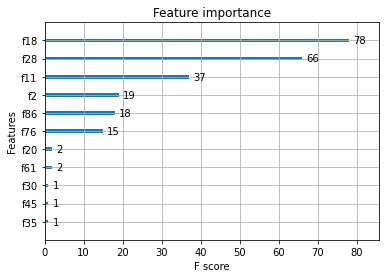

In [72]:
#apparently feature 18, but what is feature 18?
from xgboost import plot_importance
plot_importance(clfXGB, )

In [73]:
column =trainVectorDf.columns[18]
print(column)

connect


In [74]:
column = trainVectorDf.columns[66]
print (column)

port


In [75]:
column = trainVectorDf.columns[37]
print (column)

ha


In [76]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y, y_pred_xgb)

array([[31,  3],
       [ 2, 37]])

In [77]:
accuracy_score(y, y_pred_xgb)

0.9315068493150684

In [78]:
f1_score(y, y_pred_xgb)

0.9367088607594937

#TF-IDF Classification (Using XGBoost)

Performing TF-IDF results in a slightly higher performance result 

In [80]:
#Using new tokenization and stop words on TF-IDF
vectorizer = TfidfVectorizer(tokenizer=tokenize, stop_words ='english', use_idf=False)

#testTFIDF = vectorizer.fit_transform(loggingTextList)
X = vectorizer.fit_transform(train['LoggingText'])

#testTFIDFDf = pd.DataFrame(testTFID.toarray(), columns=vectorizer.get_feature_names_out())
#test = termFrequencyDf.sort_values(by='error', ascending = False)
#test

trainTFIDFDf = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names_out())
trainTFIDFDf

,'default,'exampl,0,1,2,3,4,9,9.324,9.325,...,unabl,use,workflow,workflow.java:301,workflow.java:368,workflow.java:414,workflow.java:585,workflow.java:717,workflowloggingextensionpoint.java:49,workflowloggingextensionpoint.java:87
0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.57735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.707107,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.577350,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.408248,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.577350,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
y = train['isError'].values

In [82]:
clfXGB = XGBClassifier(max_depth = 8, 
                       n_estimators= 2000, 
                       colsample_bytree=0.85, 
                       subsample=0.8, 
                       nthread=10, 
                       learning_rate =0.1,
                       gamma=0.4,
                       objective='binary:logistic',
                       eval_metric=['auc','logloss','error'],
                       early_stopping_round=50)

In [83]:
clfXGB.fit(X, y, eval_set = [(X, y), (X, y)])

[0]	validation_0-auc:0.859351	validation_0-logloss:0.652517	validation_0-error:0.150685	validation_1-auc:0.859351	validation_1-logloss:0.652517	validation_1-error:0.150685
[1]	validation_0-auc:0.944947	validation_0-logloss:0.600526	validation_0-error:0.082192	validation_1-auc:0.944947	validation_1-logloss:0.600526	validation_1-error:0.082192
[2]	validation_0-auc:0.937406	validation_0-logloss:0.568487	validation_0-error:0.150685	validation_1-auc:0.937406	validation_1-logloss:0.568487	validation_1-error:0.150685
[3]	validation_0-auc:0.969457	validation_0-logloss:0.55129	validation_0-error:0.09589	validation_1-auc:0.969457	validation_1-logloss:0.55129	validation_1-error:0.09589
[4]	validation_0-auc:0.969457	validation_0-logloss:0.52473	validation_0-error:0.150685	validation_1-auc:0.969457	validation_1-logloss:0.52473	validation_1-error:0.150685
[5]	validation_0-auc:0.967195	validation_0-logloss:0.499057	validation_0-error:0.123288	validation_1-auc:0.967195	validation_1-logloss:0.499057	va

XGBClassifier(colsample_bytree=0.85, early_stopping_round=50,
              eval_metric=['auc', 'logloss', 'error'], gamma=0.4, max_depth=8,
              n_estimators=2000, nthread=10, subsample=0.8)

In [84]:
y_pred_xgb = clfXGB.predict(X)

In [85]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y, y_pred_xgb)

array([[31,  3],
       [ 0, 39]])

In [86]:
#which features provide the greatest importance when classifying the logging text?
xgb_fea_imp=pd.DataFrame(list(clfXGB.get_booster().get_fscore().items()),
columns=['feature','importance']).sort_values('importance', ascending=False)
print('',xgb_fea_imp)

   feature  importance
7     f18          81
5     f28          54
0     f11          28
3     f86          18
1      f2          17
4     f76          13
2     f20           4
8     f30           2
6     f61           1


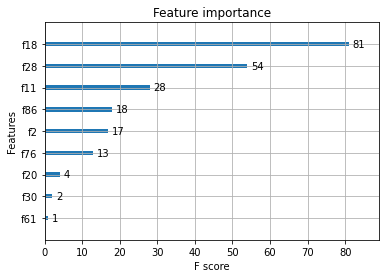

In [87]:
#apparently feature 18, but what is feature 18?
from xgboost import plot_importance
plot_importance(clfXGB, )

In [88]:
column =trainTFIDFDf.columns[18]
print(column)

connect


In [89]:
column =trainTFIDFDf.columns[28]
print(column)

error


In [90]:
column =trainTFIDFDf.columns[11]
print(column)

action


In [91]:
accuracy_score(y, y_pred_xgb)

0.958904109589041

In [92]:
f1_score(y, y_pred_xgb)

0.962962962962963

## TF-IDF visualization

([<matplotlib.axis.YTick at 0x7fdc686df910>,
 [Text(0, 0, 'connect'),
  Text(0, 0, 'start'),
  Text(0, 0, 'action'),
  Text(0, 0, 'error'),
  Text(0, 0, 'org.apache.hop.workflow.workflow.executefromstart'),
  Text(0, 0, 'neo4j'),
  Text(0, 0, 'check'),
  Text(0, 0, '0'),
  Text(0, 0, 'databas'),
  Text(0, 0, 'workflow')])

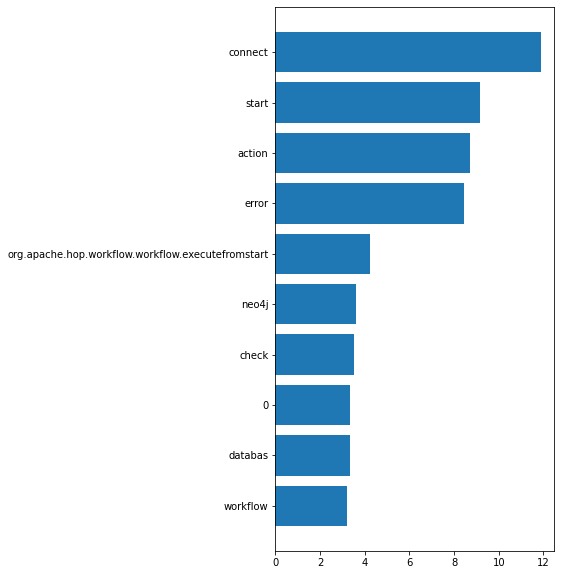

In [93]:
#get 10 most prevalent keywords in logging text
featuresRank = list(zip(vectorizer.get_feature_names_out(), [x[0] for x in X.sum(axis=0).T.tolist()]))

featuresRank = np.array(sorted(featuresRank, key=lambda x:x[1], reverse=True))

n=10
plt.figure(figsize=(5,10))
plt.barh(-np.arange(n),featuresRank[:n, 1].astype(float), height =0.8)
plt.yticks(ticks=-np.arange(n), labels=featuresRank[:n, 0])

In [94]:
for column in trainTFIDFDf.columns:
  print(column)

'default
'exampl
0
1
2
3
4
9
9.324
9.325
accept
action
avail
caus
chang
check
checkconnections.java:118
class
connect
correct
databas
db
defin
discov
durat
dvdrental
enabl
end
error
exampl
exec
execut
extensionpointhandler.java:38
extensionpointmap.java:147
fail
finish
graphdatabase.java:179
ha
hopguiworkflowgraph.java:3535
hostnam
inform
java.base/java.lang.thread.run
java.lang.except
localhost:5432
log
neo4j
neoconnection.java:175
neoconnection.java:196
neoconnection.java:210
neoconnection.java:407
new
occur
org.apache.hop.core.exception.hopdatabaseexcept
org.apache.hop.core.extension.extensionpointhandler.callextensionpoint
org.apache.hop.core.extension.extensionpointmap.callextensionpoint
org.apache.hop.neo4j.actions.check.checkconnections.execut
org.apache.hop.neo4j.logging.xp.workflowloggingextensionpoint.callextensionpoint
org.apache.hop.neo4j.shared.neoconnection.getdriv
org.apache.hop.neo4j.shared.neoconnection.getsess
org.apache.hop.neo4j.shared.neoconnection.test
org.apache.

## Comparing Frequency with Common Keywords

 How does the frequency between common keywords synonymous with the line being an error

In [95]:
#from sklearn.metrics.pairwise import cosine_similarity
#termSim = termFrequencyDf.corr().abs()

#upper = termSim.where(np.triu(np.ones(termSim.shape), k=1).astype(bool))


#dropFeatures = [column for column in upper.columns if any(upper[column] > 0.95)]


#termFrequencyDf.drop(dropFeatures, axis=1, inplace =True)
#termFrequencyDf

In [96]:
termFrequencyDf[['error', 'neo4j']]

,error,neo4j
0,0.0,0.000000
1,0.0,0.000000
2,0.0,0.000000
3,0.0,0.000000
4,0.0,0.142857
...,...,...
68,0.0,0.000000
69,0.0,0.000000
70,0.0,0.000000
71,0.0,0.000000


In [97]:
termFrequencyDf[['error','connect']]

,error,connect
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
68,0.0,0.0
69,0.0,0.0
70,0.0,0.0
71,0.0,0.0


In [98]:
termFrequencyDf[['error', 'tcp/ip']]

KeyError: ignored

In [ ]:
trainTFIDFDf[['error','db']]

In [ ]:
trainTFIDFDf.error + trainTFIDFDf.neo4j

In [ ]:
errorsByCorrelation = pd.DataFrame({
    'error': test.error,
    'neo4j': test.neo4j,
    'database':test.db,
    'connection': test.connect,
    'error + neo4j': test.error + test.neo4j,
    'error + database': test.db + test.error,
    'error + connection': test.error + test.connect
})
errorsByCorrelation.head(20)

In [ ]:
train.iloc[[47,5,39,32,71,40,25,65,27,66,42,6,42,6,72,68,74,64]]

#Error Classification (Using BERT)

In [14]:
#bert prerequisites
!pip install bert-for-tf2

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import tensorflow_hub as hub

try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers
import bert

In [16]:
#keras model does not have an F1 score, as such we must define our own functions for calculating the F1 score
#src: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [17]:
#bidirectional encoder representations from transformers (BERT)
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [18]:
def bert_encode(texts, tokenizer, max_len=50):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [19]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocab_file, do_lower_case)

In [20]:
train_input = bert_encode(train.LoggingText.values, tokenizer, max_len=50)
train_labels = train.isError.values.copy()

In [21]:
learning_rate=1e-5
decay=5e-5
max_len=50
lr_schedule = [9e-7,1e-8,5e-8,9e-8,7e-9,1e-9]
K.clear_session()

In [22]:
input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
segment_ids = Input(shape=(max_len), dtype=tf.int32, name="segment_ids")
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
clf_output = sequence_output[:, 0, :]

out = Dense(1024, activation='relu', activity_regularizer=regularizers.l2(1e-5))(clf_output)
out = Dense(1024, activation='relu', activity_regularizer=regularizers.l2(1e-5))(out)
out = Dense(1024, activation='relu', activity_regularizer=regularizers.l2(1e-5))(out)

out = Dense(1, activation='sigmoid')(out)

In [23]:
sBERT = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
# sBERT.compile(SGD(lr=learning_rate, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
sBERT.compile(Adam(lr=learning_rate, decay=decay), loss='binary_crossentropy', metrics=['accuracy',f1_m])
sBERT.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 50)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 50)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 1024),       335141889   ['input_word_ids[0][0]',         
                                 (None, 50, 1024)]                'input_mask[0][0]',         

In [24]:
init_weights = sBERT.get_weights()

In [25]:
checkpoint1 = ModelCheckpoint('best_accuracy.h5',
                             monitor='val_f1_m',
                             save_best_only=True)
# checkpoint2 = ModelCheckpoint('best_loss.h5',
#                              monitor='val_loss',
#                              save_best_only=True)


train_history = sBERT.fit(
    train_input, train_labels,
    epochs = 1,
    batch_size = 16
)
test_pred = sBERT.predict(train_input)
print(" - test_f1_score: {}".format(f1_score(train_labels,test_pred.round())))
print()

sBERT.save_weights('best_accuracy.h5')
test_accuracy = f1_score(train_labels,test_pred.round())

5/5 [==============================] - 176s 26s/step - loss: 0.5422 - accuracy: 0.8630 - f1_m: 0.8875
 - test_f1_score: 0.975



In [26]:
K.set_value(sBERT.optimizer.lr, 1e-7)
sBERT.fit(
    train_input, train_labels,
    epochs = 1,
    batch_size = 16
)
test_pred = sBERT.predict(train_input)
epoch_test_accuracy = f1_score(train_labels,test_pred.round())
print(" - test_f1_score: {}".format(epoch_test_accuracy))
print()

if epoch_test_accuracy >= test_accuracy:
    sBERT.save('best_accuracy.h5')
    test_accuracy = epoch_test_accuracy

5/5 [==============================] - 130s 25s/step - loss: 0.3222 - accuracy: 0.9726 - f1_m: 0.9771
 - test_f1_score: 0.975



In [27]:
sBERT.layers[3].trainable = False
sBERT.compile(Adam(lr=1e-6, decay=1e-6), loss='binary_crossentropy', metrics=['accuracy',f1_m])

In [29]:
# K.set_value(sBERT.optimizer.lr, 9e-8)
sBERT.fit(
    train_input, train_labels,
    validation_data=(train_input, train_labels),
    epochs = 10,
#     steps_per_epoch = 10,
#     callbacks=[checkpoint1],
    batch_size = 16
)
test_pred = sBERT.predict(train_input)
epoch_test_accuracy = f1_score(train_labels,test_pred.round())
print(" - test_f1_score: {}".format(epoch_test_accuracy))
print()

if epoch_test_accuracy >= test_accuracy:
    sBERT.save('best_accuracy.h5')
    test_accuracy = epoch_test_accuracy

Epoch 1/10
5/5 [==============================] - 107s 18s/step - loss: 0.3176 - accuracy: 0.9726 - f1_m: 0.9597 - val_loss: 0.3131 - val_accuracy: 0.9863 - val_f1_m: 0.7913
Epoch 2/10
5/5 [==============================] - 80s 18s/step - loss: 0.3110 - accuracy: 0.9863 - f1_m: 0.9895 - val_loss: 0.3068 - val_accuracy: 0.9863 - val_f1_m: 0.7913
Epoch 3/10
5/5 [==============================] - 80s 18s/step - loss: 0.3047 - accuracy: 0.9863 - f1_m: 0.9778 - val_loss: 0.3008 - val_accuracy: 0.9863 - val_f1_m: 0.7913
Epoch 4/10
5/5 [==============================] - 77s 17s/step - loss: 0.2986 - accuracy: 0.9863 - f1_m: 0.9895 - val_loss: 0.2948 - val_accuracy: 0.9863 - val_f1_m: 0.7913
Epoch 5/10
5/5 [==============================] - 77s 17s/step - loss: 0.2927 - accuracy: 0.9863 - f1_m: 0.9895 - val_loss: 0.2889 - val_accuracy: 0.9863 - val_f1_m: 0.7913
Epoch 6/10
5/5 [==============================] - 77s 17s/step - loss: 0.2869 - accuracy: 0.9863 - f1_m: 0.9882 - val_loss: 0.2833 - v

# Classification

Logistic Regression

In [ ]:
clf = LogisticRegression()

In [ ]:
scores = model_selection.cross_val_score(clf, trainVector, train['isError'], cv = 5, scoring="f1")
scores

In [ ]:
clf.fit(testVector, train['isError'])

Kmeans

In [ ]:
clfTFIDF = LogisticRegression()
scores = model_selection.cross_val_score(X, trainTFIDF, train['isError'], cv = 5, scoring='f1')
scores

In [ ]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters = 4)
model.fit(train)
model.fit

In [ ]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(4):
  topWords =[terms[ind] for ind in order_centroids[i, :5]]
  print("Cluster {}: {}".format(i, ' '.join(topWords)))